#### For each good fly, I want to run a few basic analyses:
    - Plot PC 2D Hist maps (first ~50-100 PCs)
    - Foward and Rotational R2 predictions for a distribution of num_PCs
    - Some visualization of which 2D maps are being used by each model
    - Spatial PC distribution for forward and rotation
    
#### Let's order the steps.
    Q1: What is best num_pcs to use across all flies?
        - Load a fly's PCs
        - Predict with different #PCs
        - Save coef figure
        - Append R2s
        - Finally, compare R2 distribution across flies
    Q2: For that num_pcs, compare the 2Dhist plots across flies with high/different weights from forward and turning.
        - 
        
#### Final figures:
    - Show predicted behavior on completely held out data
        - ie, predict with standard CV or whatever, but only give the model 90% of the data!

In [1]:
import numpy as np
from time import time
import os
import sys
import scipy
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.interpolate import interp1d
import pandas as pd
import psutil
import scipy as sp
import scipy.ndimage
from tqdm import tqdm
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import bigbadbrain as bbb
from scipy.linalg import toeplitz
import scipy.linalg as sl
from scipy.signal import convolve2d
from scipy.signal import convolve
import sklearn
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn import linear_model
from sklearn.decomposition import FastICA

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import cv2

import statsmodels.api as sm

%matplotlib inline
plt.rcParams.update({'font.size': 20})

### Lets start with zscored behavior and multivariate. 

In [2]:
directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_19/func_0'

In [3]:
brain_path = os.path.join(directory, 'brain_zscored_green.nii')
brain = bbb.load_numpy_brain(brain_path)
dims = bbb.get_dims(brain)
print('brain shape is x,y,z,t {}'.format(brain.shape))


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 15.40 sec
brain shape is x,y,z,t (128, 84, 49, 4554)


In [4]:
timestamps = bbb.load_timestamps(os.path.join(directory, 'imaging'))
fictrac = bbb.load_fictrac(os.path.join(directory, 'fictrac'))


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 58.66 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 2.91 sec


In [5]:
t0 = time()
save_file = os.path.join(directory, 'pca', 'scores_(spatial).npy')
pca_spatial = np.load(save_file)
save_file = os.path.join(directory, 'pca', 'loadings_(temporal).npy')
pca_loadings = np.load(save_file)
print('Duration: {}'.format(time()-t0))

Duration: 26.695605993270874


In [6]:
def interp_fictrac(fictrac, behavior, fps, resolution, expt_len, timestamps, interp_to):
    camera_rate = 1/fps * 1000 # camera frame rate in ms
    sphere_radius = 4.5e-3
    filter_window = 51
    
    x_original = np.arange(0,expt_len,camera_rate)
    
    if behavior == 'all':
        dx = np.asarray(fictrac['dRotLabX'])
        dy = np.asarray(fictrac['dRotLabY'])
        dz = np.asarray(fictrac['dRotLabZ'])
        dx = scipy.signal.savgol_filter(dx,filter_window,3) * sphere_radius * 50 * 100 * 10
        dy = scipy.signal.savgol_filter(dy,filter_window,3) * sphere_radius * 50 * 100 * 10
        dz = scipy.signal.savgol_filter(dz,filter_window,3) * 180 / np.pi * 50
        fictrac_smoothed = np.sqrt(dx*dx + dy*dy + dz*dz)
    elif behavior == 'Y':
        dy = np.asarray(fictrac['dRotLabY'])
        fictrac_smoothed = scipy.signal.savgol_filter(dy,filter_window,3) * sphere_radius * 50 * 100 * 10
    elif behavior == 'Z':
        dz = np.asarray(fictrac['dRotLabZ'])
        fictrac_smoothed = scipy.signal.savgol_filter(dz,filter_window,3) * 180 / np.pi * 50
    else:
        print('invalid behavior')
    
    #fictrac_smoothed = np.abs(fictrac_smoothed)
    fictrac_interp_temp = interp1d(x_original, fictrac_smoothed, bounds_error = False)
    xnew = np.arange(0,expt_len,resolution) #0 to last time at subsample res
    
    if interp_to is 'timestamps':
        fictrac_interp = fictrac_interp_temp(timestamps[:,25])
    elif interp_to is 'xnew':
        fictrac_interp = fictrac_interp_temp(xnew)
    else:
        print('Invalid interp_to ({})'.format(interp_to))

    # Replace Nans with zeros (for later code)
    np.nan_to_num(fictrac_interp, copy=False);
    
    return fictrac_interp

In [7]:
resolution = 50 #desired resolution in ms
expt_len = 1000*30*60
fps = 50 #of fictrac camera
xnew = np.arange(0,expt_len,resolution)

fictracs_high_res = {}
for behavior in ['all', 'Y', 'Z']:
    fictracs_high_res[behavior] = interp_fictrac(fictrac, behavior, fps, resolution, expt_len, timestamps, 'xnew')

fictracs = {}
for behavior in ['all', 'Y', 'Z']:
    fictracs[behavior] = interp_fictrac(fictrac, behavior, fps, resolution, expt_len, timestamps, 'timestamps')

### Z-score PCA and Fictrac

In [8]:
pca_loadings_std = np.std(pca_loadings,axis=0)
pca_loadings= np.divide(pca_loadings,pca_loadings_std)

In [9]:
for behavior in ['Y', 'Z']:
    fictracs_std = np.std(fictracs[behavior])
    fictracs[behavior] = np.divide(fictracs[behavior],fictracs_std)

# Fit models

In [16]:
def get_r2(true, prediction):
    u = np.sum((prediction-true)**2)
    v = np.sum((true-np.mean(true))**2)
    return 1 - u / v

In [24]:
models = []
Y_glm = np.vstack((fictracs['Y'], fictracs['Z'])).T

for num_pcs in [10,25,50,75,100,200,300,500,1000,2000]:
    t0 = time()
    models.append({'num_pcs': num_pcs, 'model': MultiTaskLassoCV()})
    X_glm = pca_loadings[:,:num_pcs]
    
    # Fit model
    models[-1]['model'].fit(X_glm, Y_glm)
    
    # Get scores
    prediction = models[-1]['model'].predict(X_glm)
    models[-1]['score_Y'] = get_r2(fictracs['Y'], prediction[:,0])
    models[-1]['score_Z'] = get_r2(fictracs['Z'], prediction[:,1])
    models[-1]['score'] = models[-1]['model'].score(X_glm, Y_glm)
    
    print('Num PCs: {} | Dur: {:0.0f}s'.format(num_pcs, time()-t0))

Num PCs: 10 | Dur: 0s
Num PCs: 25 | Dur: 1s
Num PCs: 50 | Dur: 2s
Num PCs: 75 | Dur: 4s
Num PCs: 100 | Dur: 6s
Num PCs: 200 | Dur: 13s
Num PCs: 300 | Dur: 21s
Num PCs: 500 | Dur: 40s
Num PCs: 1000 | Dur: 107s
Num PCs: 2000 | Dur: 450s


In [38]:
for i in range(10):
    print(models[i]['score'])

0.14457529079253031
0.23039074553725405
0.3750075463478413
0.392758204595327
0.4006673030684456
0.4196101121259699
0.43520609126316445
0.46685658991247275
0.5054327470374996
0.45753824452811115


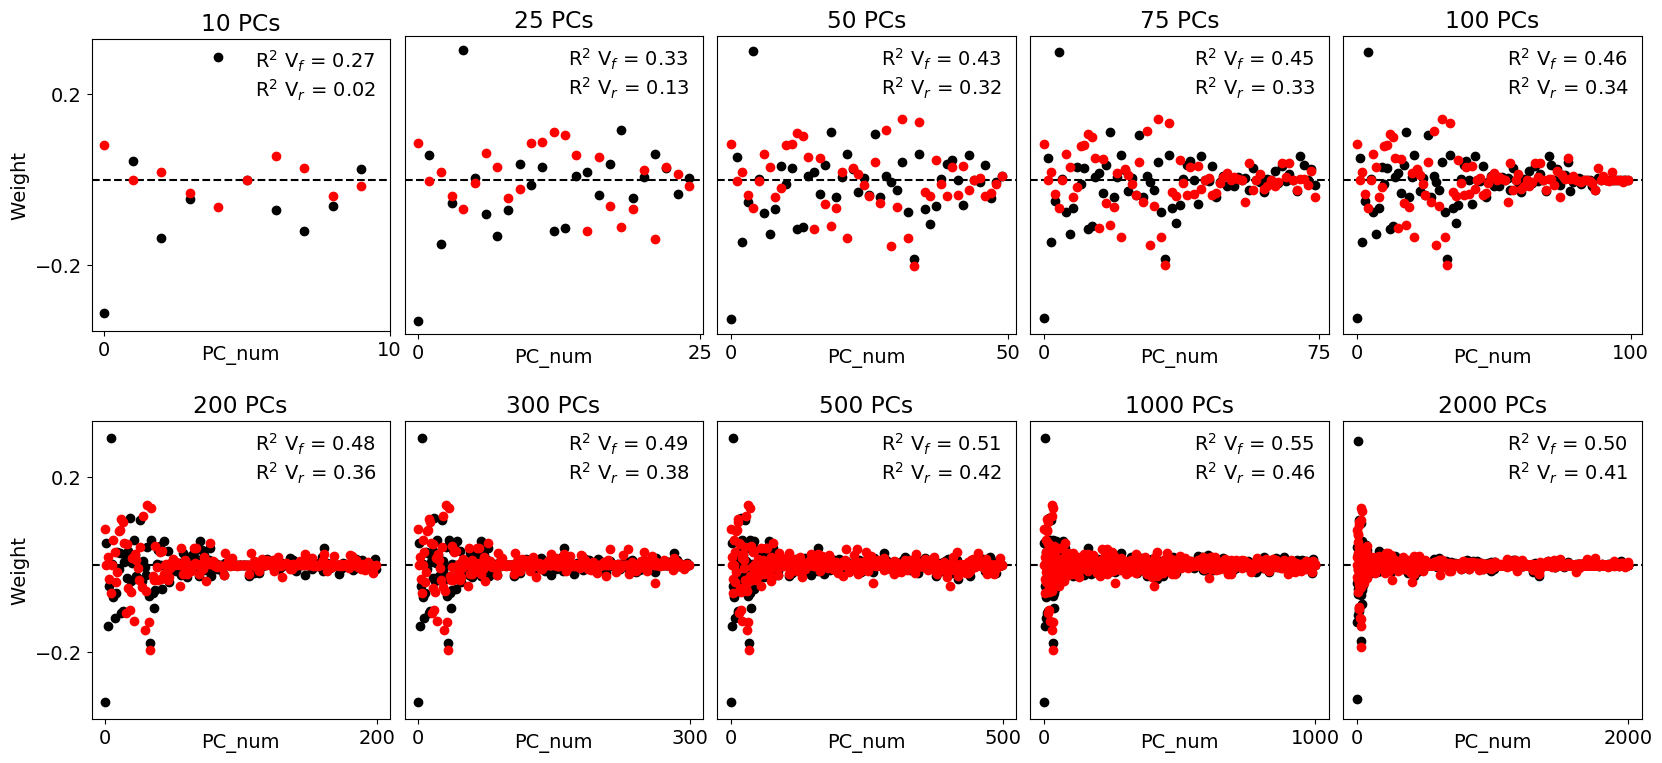

In [118]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 14})
#plt.style.use('default')
#plt.style.use('fivethirtyeight')
plot = {}

for k, model in enumerate(models):
    if 
    if k == 0:
        plot[k] = plt.subplot(2,5,k+1)
    else:
        plot[k] = plt.subplot(2,5,k+1,sharey=plot[0])
    if k not in [0,5]:
        plot[k].yaxis.set_visible(False)
    else:
        plot[k].set_ylabel('Weight')
        plot[k].set_yticks([-0.2, 0.2])
    
    plot[k].axhline(0,color='k',linestyle='--')
    plot[k].plot(models[k]['model'].coef_[0,:],'o',color='k')
    plot[k].plot(models[k]['model'].coef_[1,:],'o',color='r')
    #plt.title('#PCs: {}; Score: {:.2f}'.format(models[k]['num_pcs'],
                                               #models[k]['score']))

    #plt.ylabel('Weight')
    plot[k].set_xlabel('PC_num')
    plot[k].axis('auto')
    #plot[k].set_ylabel('classic')
    plot[k].set_aspect(1.0/plot[k].get_data_ratio())
    plot[k].set_xticks([0, models[k]['num_pcs']])
    plot[k].xaxis.set_label_coords(0.5, -0.05)
    plot[k].set_title('{} PCs'.format(models[k]['num_pcs']))

    plot[k].text(.55,.9,'R$^2$ V$_f$ = {:0.2f}'.format(models[k]['score_Y']),
                 transform=plot[k].transAxes)
    plot[k].text(.55,.8,'R$^2$ V$_r$ = {:0.2f}'.format(models[k]['score_Z']),
                 transform=plot[k].transAxes)
    
    
    #plot[k].set_title(r"$\frac{\sigma}{\sqrt{\mu}}$")
    #plot[k].set_title("$\mathregular{N_i}$")
    


plt.subplots_adjust(wspace=.05, hspace=0)
#plt.suptitle('SHUFFLE. MultiTaskLassoCV, fly_19, z-scored PCs and behavior')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr + '_{}_coefs.png'.format('fly_19'))
plt.savefig(fname,dpi=300,bbox_inches='tight')

In [269]:
flies = ['fly_1',
         'fly_3',
         'fly_5',
         'fly_7',
         'fly_19',
         'fly_21',
         'fly_48',
         'fly_51',
         'fly_54',
         'fly_68']

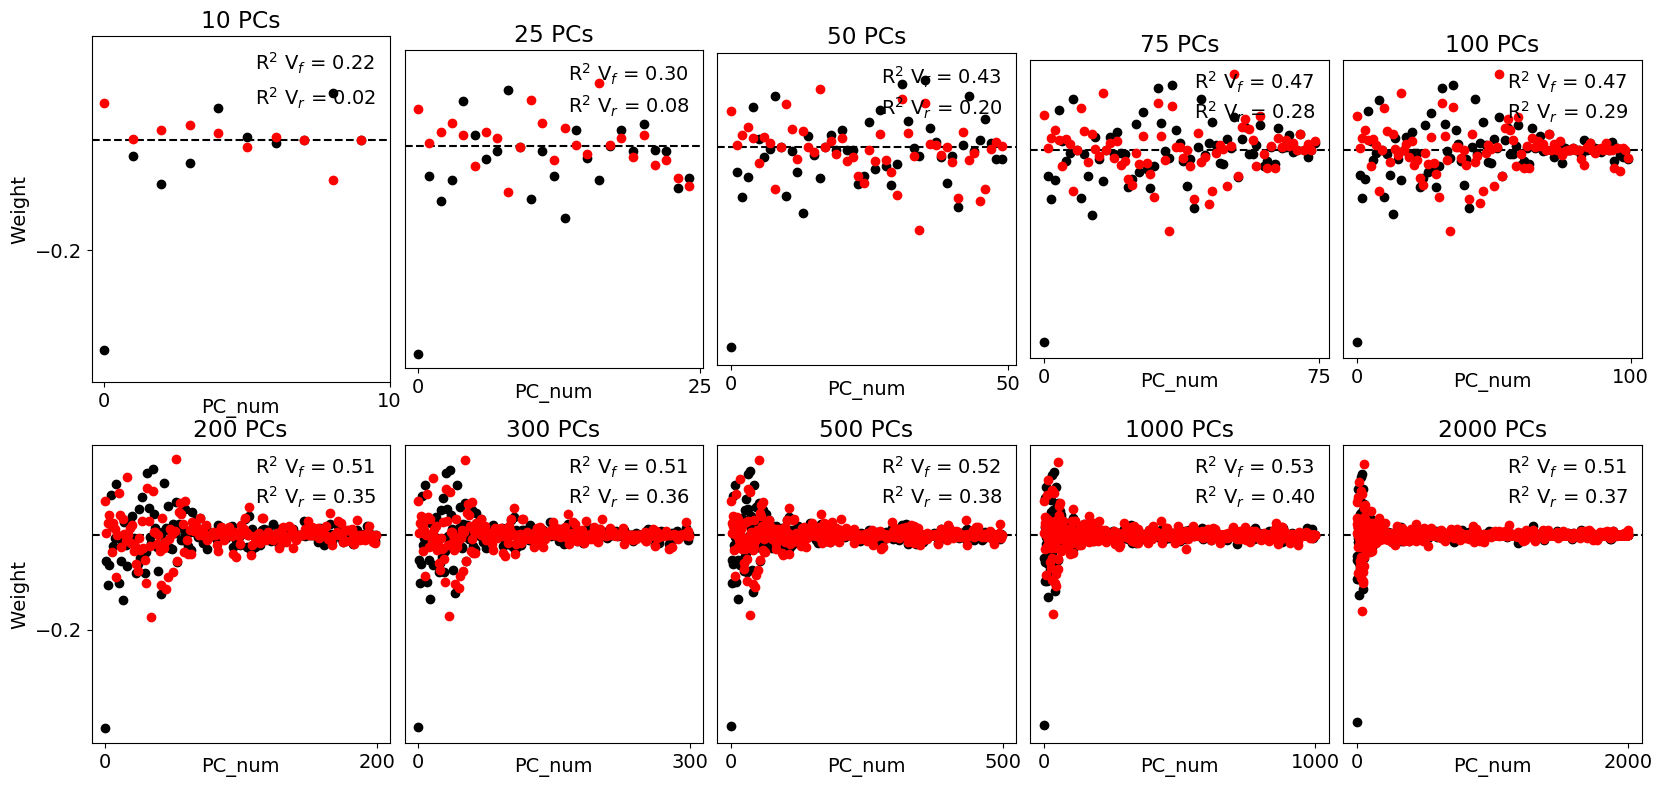

In [273]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 14})
#plt.style.use('default')
#plt.style.use('fivethirtyeight')

for fly in flies:
    plot = {}
    plt.cla()
    plt.clf()
    for k, model in enumerate(models):
        k = k%10
        if model['fly'] != fly:
            continue

        if k == 0:
            plot[k] = plt.subplot(2,5,k+1)
        else:
            plot[k] = plt.subplot(2,5,k+1,sharey=plot[0])

        if k not in [0,5]:
            plot[k].yaxis.set_visible(False)
        else:
            plot[k].set_ylabel('Weight')
            plot[k].set_yticks([-0.2, 0.2])

        plot[k].axhline(0,color='k',linestyle='--')
        plot[k].plot(model['coef_Y'],'o',color='k')
        plot[k].plot(model['coef_Z'],'o',color='r')
        #plt.title('#PCs: {}; Score: {:.2f}'.format(models[k]['num_pcs'],
                                                   #models[k]['score']))

        #plt.ylabel('Weight')
        plot[k].set_xlabel('PC_num')
        plot[k].axis('auto')
        #plot[k].set_ylabel('classic')
        plot[k].set_aspect(1.0/plot[k].get_data_ratio())
        plot[k].set_xticks([0, model['num_pcs']])
        plot[k].xaxis.set_label_coords(0.5, -0.05)
        plot[k].set_title('{} PCs'.format(model['num_pcs']))

        plot[k].text(.55,.9,'R$^2$ V$_f$ = {:0.2f}'.format(model['score_Y']),
                     transform=plot[k].transAxes)
        plot[k].text(.55,.8,'R$^2$ V$_r$ = {:0.2f}'.format(model['score_Z']),
                     transform=plot[k].transAxes)


        #plot[k].set_title(r"$\frac{\sigma}{\sqrt{\mu}}$")
        #plot[k].set_title("$\mathregular{N_i}$")



    plt.subplots_adjust(wspace=.05, hspace=0)
    #plt.suptitle('SHUFFLE. MultiTaskLassoCV, fly_19, z-scored PCs and behavior')

    save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
    timestr = time.strftime("%Y%m%d-%H%M%S")
    fname = os.path.join(save_path, timestr + '_{}_coefs.png'.format(fly))
    plt.savefig(fname,dpi=300,bbox_inches='tight')

In [121]:
Y_scores = []
Z_scores = []
PCs = []

for i in range(len(models)):
    Y_scores.append(models[i]['score_Y'])
    Z_scores.append(models[i]['score_Z'])
    PCs.append(models[i]['num_pcs'])

In [279]:
PCs

[10, 25, 50, 75, 100, 200, 300, 500, 1000, 2000]

In [278]:
scores_Y = {}
scores_Z = {}
for fly in flies:
    scores_Y[fly] = [model['score_Y'] for model in models if model['fly'] == fly]
    scores_Z[fly] = [model['score_Z'] for model in models if model['fly'] == fly]

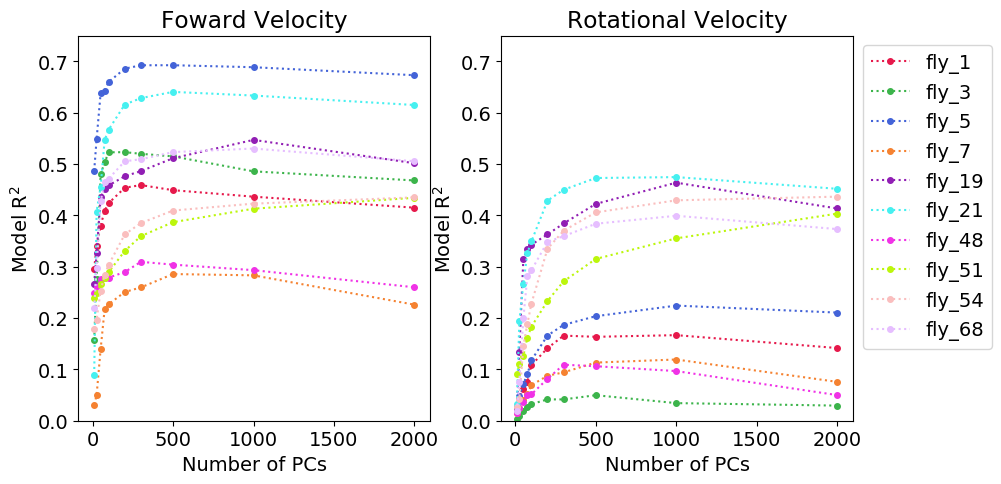

In [321]:
plt.figure(figsize=(10,5))
ax_Y = plt.subplot(121)
ax_Z = plt.subplot(122)
colors = ['#e6194b','#3cb44b', '#4363d8',
          '#f58231', '#911eb4', '#46f0f0', '#f032e6',
          '#bcf60c', '#fabebe', '#e6beff',
          '#9a6324', '#fffac8', '#800000', '#aaffc3',
          '#808000', '#ffd8b1', '#000075', '#808080']

#colors = ['#B03A2E', '#76448A', '#2874A6', '#148F77', '#B7950B',
#          '#A04000', '#283747', '#7FB3D5', '#D7BDE2', '#ABEBC6']

for i,fly in enumerate(flies):
    ax_Y.plot(PCs, scores_Y[fly], marker='o',markersize=4,color=colors[i],label=fly,linestyle=':')
    ax_Z.plot(PCs, scores_Z[fly], marker='o',markersize=4,color=colors[i],label=fly,linestyle=':')
#ax.set_xscale('log')
ax_Y.set_xlabel('Number of PCs')
ax_Y.set_ylabel('Model R$^2$')

ax_Z.set_xlabel('Number of PCs')
ax_Z.set_ylabel('Model R$^2$')
#plt.legend()
ax_Y.set_title('Foward Velocity')
ax_Z.set_title('Rotational Velocity')

ax_Y.set_ylim(0,.75)
ax_Z.set_ylim(0,.75)

ax_Z.legend(bbox_to_anchor=(1, 1))

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr + '_coefs_all.png')
plt.savefig(fname,dpi=300,bbox_inches='tight')

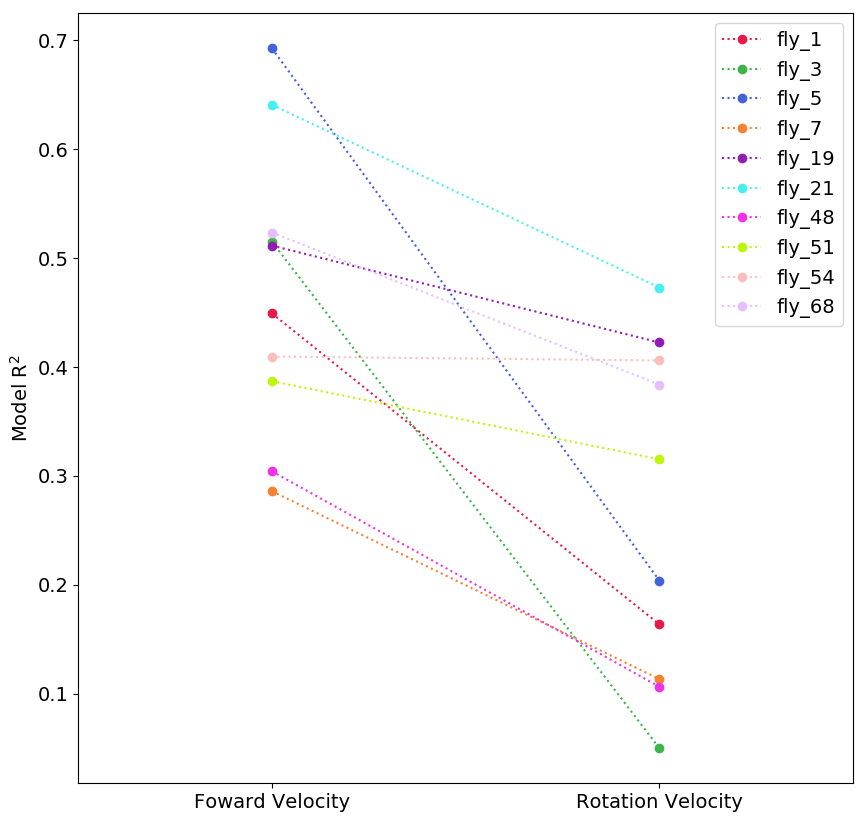

In [338]:
plt.figure(figsize=(10,10))
ax = plt.subplot(111)
for i, fly in enumerate(flies):
    ax.plot([1,2], [scores_Y[fly][-3], scores_Z[fly][-3]], linestyle=':',marker='o', color=colors[i],label=fly)
    
ax.set_xticklabels(['Foward Velocity', 'Rotation Velocity'])
ax.set_xticks([1, 2])
ax.set_xlim(0.5,2.5)
ax.set_ylabel('Model R$^2$')
ax.legend()

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr + '_coefs_all_500PCs.png')
plt.savefig(fname,dpi=300,bbox_inches='tight')

# Reconstruct brain

In [259]:
import json
data = json.load()

AttributeError: 'str' object has no attribute 'read'

In [263]:
file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/20191106_analysis/20191106_models.json'
with open(file) as json_file:
    models = json.load(json_file)

In [262]:
data[0]

{'coef_Y': [0.006240564478381373,
  -0.03696323110700434,
  0.14803076809136456,
  -0.15173859802020975,
  -0.14873608026794394,
  0.13252173140125548,
  -0.29176597557177414,
  0.025970095376289914,
  -0.036007684667967235,
  0.304120778465223],
 'coef_Z': [-0.007909465988064725,
  -0.01481168304495498,
  0.0023804978116918236,
  -0.08072709164152847,
  -0.018146639385701536,
  -0.02159561494579837,
  -0.027564312286649854,
  -0.026412477101620854,
  -0.002115063041530677,
  0.08179584845213565],
 'fly': 'fly_1',
 'num_pcs': 10,
 'score': 0.15713249817922123,
 'score_Y': 0.29609411843721123,
 'score_Z': 0.018170877921231066}

In [172]:
coefs = models[2]['model'].coef_[0,:]

In [254]:
coefs = models[2]['model'].coef_[1,:]
out_50 = np.tensordot(coefs, pca_spatial[:50,:,:,:],axes=1)

In [208]:
save_file = os.path.join(directory, '20191106_analysis', 'forward_50_1000_difference.nii')
bbb.save_brain(save_file, out_1000-out_50)


~~ save_brain ~~
Current memory usage: 39.51GB
save_brain done. Duration: 10.45 ms


In [199]:
directory

'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_19/func_0'

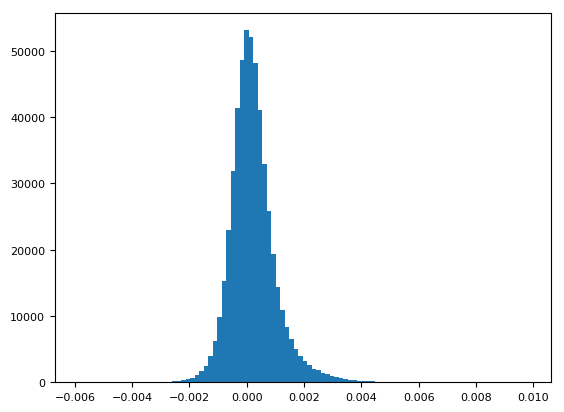

In [229]:
plt.rcParams.update({'font.size': 8})

plt.hist(out_50.flatten(),bins=100);

In [255]:
thresh_low = -.0015
thresh_high = 0.0015

low = out_50 > thresh_low
high = out_50 < thresh_high

middle = low & high

out_50[middle] = 0

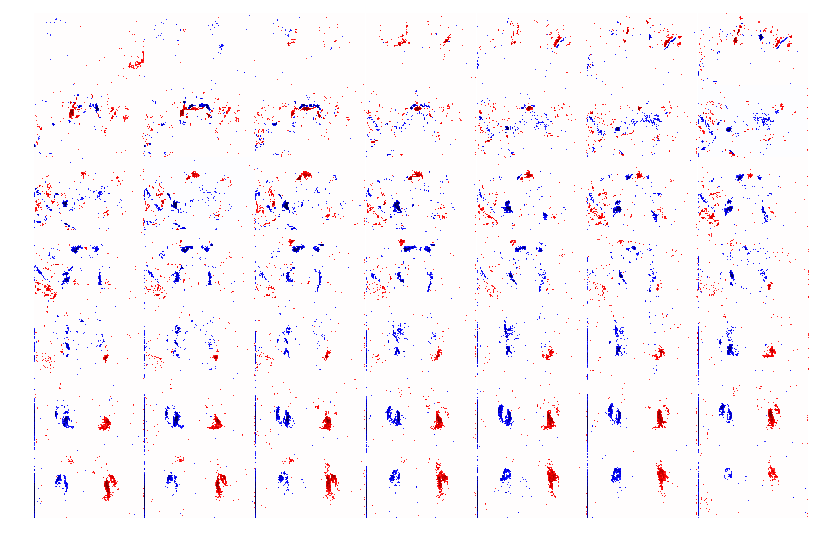

In [257]:
plt.figure(figsize=(10,np.divide(84,128)*10))
for i in range(49):
    ax = plt.subplot(7,7,i+1)
    ax.imshow(out_50[:,:,i].T,cmap='seismic',vmin = -.004,vmax=.004)
    ax.axis('off')
    ax.set_aspect('equal')

plt.subplots_adjust(wspace=0, hspace=0)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, timestr + '_{}_rotation.png'.format('fly_19'))
plt.savefig(fname,dpi=300,bbox_inches='tight')

In [ ]:
brain shape is x,y,z,t (128, 84, 49, 4554)

In [209]:
7*7

49

In [167]:
# THIS IS HOW TO FIX THE SPATIAL PART
pca_spatial.shape = (4554, -1)
pca_spatial.shape = (4554, 128, 84, 49)

In [ ]:
np.multiply(pca_spatial[:,:,25,0].T, pca_[0,idx]